# Calculate loss score of false triples
学習した埋め込みモデルを使ってスコアなどを計算する．
計算結果の構造は下記の通り．


- model_random_seed
    - model_info
        - hits@k
        - vanilla hits@k
    - eval_results
        - data_random_seed
            - false_dataset(including calculated score)
            - precision_recall_curve
                - precision
                - recall
                - auc
            - true_positive_ratio
                - top_k

## modules

In [1]:
import torch
import json
import pylab as plt
import pandas as pd
from sources.evaluation import vanilla_hits_at_k
from IPython.display import display, HTML
from pykeen.datasets import get_dataset
from util.databinder import DataBinder
from pykeen.evaluation import RankBasedEvaluator
from sklearn.metrics import precision_recall_curve, auc
from util.databinder import DataBinder

/home/acg16558pn/kg_20240423/lib/python3.10/site-packages/pykeen/evaluation/evaluator.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## variables, functions and classes

In [2]:
def load_json_from_file(f:str):
    with open(f, 'r') as fin:
        dict_data = json.load(fin)
    return dict_data

## parameters

In [3]:
# directory for trained model
dir_model = './models/20240803/kge_try2_transe_fb15k237'

# directory for false triples
dir_false_dataset = './data/processed/20240803/false_dataset_try1_fb15k237'

# direcory for report
dir_report = './reports/20240803/eval_results_try2_fb15k237_transe_v2'

## main

### input check

In [4]:
db_model = DataBinder(dir_model)
db_false_dataset = DataBinder(dir_false_dataset)

INFO:root:Loaded info from ./models/20240803/kge_try2_transe_fb15k237/info.json
INFO:root:Loaded info from ./data/processed/20240803/false_dataset_try1_fb15k237/info.json


In [5]:
if db_model.get('dataset_name') != db_false_dataset.get('dataset_name'):
    raise Exception('a name of data set is inconsistent between knowledge graph embedding model and data set')

### read model & data

In [6]:
dataset = get_dataset(dataset=db_model.get('dataset_name'), dataset_kwargs={'create_inverse_triples':True})

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///home/acg16558pn/.data/pykeen/datasets/fb15k237/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///home/acg16558pn/.data/pykeen/datasets/fb15k237/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///home/acg16558pn/.data/pykeen/datasets/fb15k237/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///home/acg16558pn/.data/pykeen/datasets/fb15k237/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation


In [7]:
dict_models = {k:torch.load(f'{dir_model}/{k}/trained_model.pkl') for k in db_model.get('list_random_seeds')}
dict_model_info = {k:load_json_from_file(f'{dir_model}/{k}/results.json') for k in db_model.get('list_random_seeds')}

In [8]:
db_false_triples = DataBinder(target_dir=dir_false_dataset)
list_random_seed = db_false_triples.get('list_random_seed')
dict_false_triples = {}
for random_seed in list_random_seed:
    i = int(random_seed)
    dict_false_triples[i] = {}
    dict_false_triples[i]['tf'] = db_false_triples.get(f'tf_{random_seed}')
    dict_false_triples[i]['tt'] = db_false_triples.get(f'tt_{random_seed}')
    dict_false_triples[i]['df_feature'] = db_false_triples.get(f'df_tt_tf_features_{random_seed}')

INFO:root:Loaded info from ./data/processed/20240803/false_dataset_try1_fb15k237/info.json


### evaluate models

In [9]:
dict_eval_results = {model_random_seed: {'model_info':{}, 'eval_results':{}} for model_random_seed in db_model.get('list_random_seeds')}

Hits@k of the knowledge graph embedding model (calculated by pykeen)

In [10]:
for seed in db_model.get('list_random_seeds'):
    dict_data = {}
    for i in [1,3,5,10]:
        dict_data[i] = dict_model_info[seed]['metrics']['both']['realistic'][f'hits_at_{i}']
    dict_eval_results[seed]['model_info']['hits@k'] = dict_data

Hits@k of knowledge graph embeddign model (calculated by homemade function)

In [11]:
for seed in db_model.get('list_random_seeds'):
    dict_data = vanilla_hits_at_k(dict_models[seed], dataset.testing.mapped_triples)
    dict_eval_results[seed]['model_info']['vanilla hits@k'] = dict_data

Calculate score and true nagative ratio

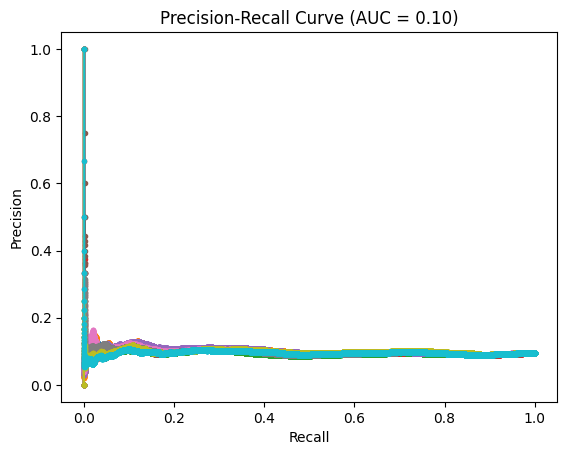

In [12]:
fig_pr_curve, ax = plt.subplots()
# for each model random seed
for model_random_seed in db_model.get('list_random_seeds'):

    # for eacch data set random seed
    for random_seed in dict_false_triples.keys():

        # prepaer for ealuation
        kge_model = dict_models[model_random_seed]
        
        tf = dict_false_triples[random_seed]['tf']
        tt = dict_false_triples[random_seed]['tt']
        df_feature = dict_false_triples[random_seed]['df_feature']

        # calculate socre
        score_tf = kge_model.score_hrt(tf.mapped_triples).cpu().detach().numpy()
        df_feature['score'] = score_tf
    
        score_tt = kge_model.score_hrt(tt.mapped_triples).cpu().detach().numpy()
        df_feature['score(org)'] = score_tt
    
        dict_eval_results[model_random_seed]['eval_results'][random_seed] = {}
        dict_eval_results[model_random_seed]['eval_results'][random_seed]['false_dataset'] = df_feature

        # calculate true positive ratio
        n = len(df_feature)
        df_sorted_feature = df_feature.sort_values('score')
        dict_eval_results[model_random_seed]['eval_results'][random_seed]['true_positive_ratio'] = {}
        for k in [0.01, 0.03, 0.05]:
            n_top = int(n*k)
            df = df_sorted_feature.head(n_top)
            threashold = df['score'].max()
            tn = len(df[df['is-error']==True])
            fp = len(df[df['is-error']==False])
            tnr = tn/(fp+tn)

            dict_eval_results[model_random_seed]['eval_results'][random_seed]['true_positive_ratio'][k] = {} 
            dict_eval_results[model_random_seed]['eval_results'][random_seed]['true_positive_ratio'][k]['value'] = tnr
            dict_eval_results[model_random_seed]['eval_results'][random_seed]['true_positive_ratio'][k]['threashold'] = threashold   

        # calculate precision and recall curve
        y_true = df_feature['is-error']
        y_scores = -df_feature['score']
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall, precision)

        dict_eval_results[model_random_seed]['eval_results'][random_seed]['precision_recall_curve'] = {}
        dict_eval_results[model_random_seed]['eval_results'][random_seed]['precision_recall_curve']['precision'] = precision
        dict_eval_results[model_random_seed]['eval_results'][random_seed]['precision_recall_curve']['recall'] = recall
        dict_eval_results[model_random_seed]['eval_results'][random_seed]['precision_recall_curve']['auc'] = auc
        
        ax.plot(recall, precision, marker='.')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')

In [13]:
tnr

0.08129285014691479

### save results

In [14]:
db = DataBinder(target_dir=dir_report)

INFO:root:Create ./reports/20240803/eval_results_try2_fb15k237_transe_v2


In [15]:
db.add('dict_eval_results', dict_eval_results)
db.add('db_model', db_model)
db.add('db_false_dataset', db_false_dataset)

INFO:root:Saved info at 2024-08-07 06:20:57
INFO:root:Saved info at 2024-08-07 06:20:57
INFO:root:Saved info at 2024-08-07 06:20:57


'./reports/20240803/eval_results_try2_fb15k237_transe_v2/db_false_dataset.pt'